In [49]:
# this script implments the example in http://www.ees.nmt.edu/outside/courses/GEOP505/Docs/kalman.pdf
using DifferentialEquations
using Plots
using Kalman
using Statistics
using Random
using LinearAlgebra 
using GaussianDistributions
using GaussianDistributions: ⊕ # independent sum of Gaussian r.v.

In [51]:
# some helper functions, likely never used. 
function movingaverage(X::Vector,numofele::Int)
    BackDelta = div(numofele,2) 
    ForwardDelta = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    len = length(X)
    Y = similar(X)

    for n = 1:len
        lo = max(1,n - BackDelta)
        hi = min(len,n + ForwardDelta)
        Y[n] = mean(X[lo:hi])
    end
    return Y
end

function average_every(nn::Int, X::Vector)
    l = length(X)    
    r = Int(floor(l/nn))
    aX = similar(X, r)
    for b in 1:length(aX)
        sidx = (b * nn) - nn + 1
        eidx = (b * nn)
        mval = sum(X[sidx:eidx])
        aX[b] = mval
    end
    return aX
end

average_every (generic function with 1 method)

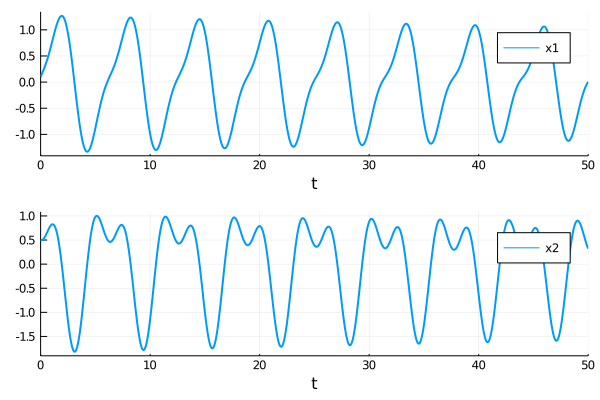

In [2]:
## Lets solve the ODE first without using Kalman Filters
function theo_ode!(du,u,p,t)
    du[1] = u[2]
    du[2] = -0.01*u[2] - u[1] + sin(2*t)
end

u₀ = [0.1, 0.5]                       # initial state vector
tspan = (0.0,50.0)                # time interval

prob = ODEProblem(theo_ode!,u₀,tspan)
sol = solve(prob)

plot(sol,linewidth=2,xaxis="t",label=["x1" "x2"],layout=(2,1))

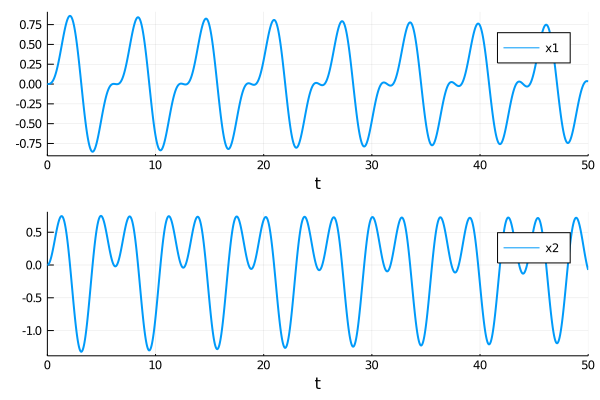

In [3]:
## running the same ODE but in matrix format
A = [0 1; -1 -0.01]
B = [1 0; 0 1]
u0 = [0, 0]
tspan = (0.0,50.0)
f(u,p,t) = A*u + B*[0, sin(2*t)]
prob = ODEProblem(f,u0,tspan)
sol = solve(prob)

plot(sol,linewidth=2,xaxis="t",label=["x1" "x2"],layout=(2,1))

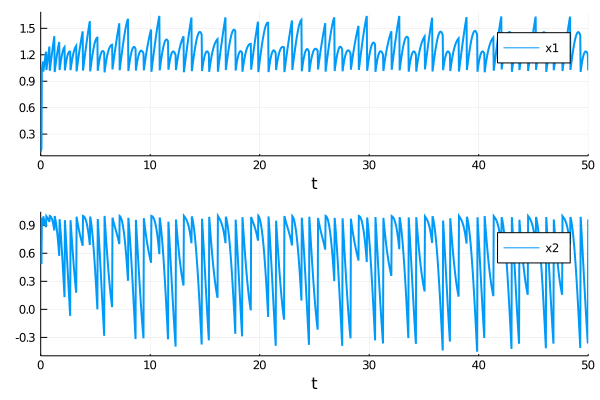

In [12]:
## a test peice of code to see how callback functions work in DE.jl
function cb_ode!(du,u,p,t)
    du[1] = u[2]
    du[2] = -0.01*u[2] - u[1] + sin(2*t)
end

condition(u,t,integrator) = true
function affecttwo!(integrator, value)
    integrator.u[1] = value
    integrator.u[2] = value
end
outsidevalue = 1
cb = DiscreteCallback(condition, int -> affecttwo!(int, outsidevalue))

u₀ = [0.1, 0.5]                       # initial state vector
tspan = (0.0,50.0)                # time interval

prob = ODEProblem(cb_ode!,u₀,tspan)
sol = solve(prob, callback=cb)

plot(sol,linewidth=2,xaxis="t",label=["x1" "x2"],layout=(2,1))

In [31]:
## Kalman filter functions

# the true system state can be viewed in figure 1 of http://www.ees.nmt.edu/outside/courses/GEOP505/Docs/kalman.pdf

# (mock) data
ys = [[0.8],[1.4],[0.7],[-1.1],[-1.5],[-0.9],[-0.2],[1.3],[1.8],[-0.3],[-1.6],[-1.1],[-0.4],[1.1],[1.8],[0.6],[-0.3],[-0.7],[-0.8],[-0.1],[0.9],[0.3],[-0.7],[-0.3],[-0.4],[0.1],[0.7],[-0.4],[-0.9],[-0.2],[0.4],[-0.2],[0.1],[0.2],[-0.4],[0],[1],[0.5],[0.3],[0.6],[-0.4],[-0.9],[0],[0.4],[0.3],[0.8],[0.1],[-1.6],[-1.3],[-0.1]]

# time array
Δt = 0.001
N = collect(0:Δt:50.00)
popfirst!(N)

function run_kalman(correct=false)
    ## converting the above differential equaiton into matrix form for kalman formulation
    A = [0 1; -1 -0.01]
    B = [1 0; 0 1]
    Q = [0.0005 0.0; 0.0 0.0005]

    # prior for time 0
    x0 = [0, 0]
    P0 = [0.5 0.0; 0.0 0.5]
    ## Use Kalman filters. 

    ## Suppose we only observe the x1 component every 100 time steps. c
    # measurement
    #H = [0.0 1.0]
    H = [1.0 0.0]
    R = [0.0005]

    I = [1 0; 0 1]
    p = Gaussian(x0, P0) # define the initial condition
    ps = []
    for t in N ## go through the times
        # use old value of p to update and get new value of p
        push!(ps, p) # save filtered density 
       
        mval = (I + Δt*A)*p.μ + (Δt*B)*[0, sin(2*t)] ## discretized value. 
        p = Gaussian(mval, A*p.Σ*A' + Q)    
        
        if correct 
            # correct at integer values of t
            if t in 1:50
                #println("index: $t")
                idx = Int(t)
                p, yres, _ = Kalman.correct(Kalman.JosephForm(), p, (Gaussian(ys[idx], R), H))
                #p, yres, _ = mycorrect(p, (Gaussian(ys[idx], R), H))
            end
        end
        
    end
    return ps
end

run_kalman (generic function with 2 methods)

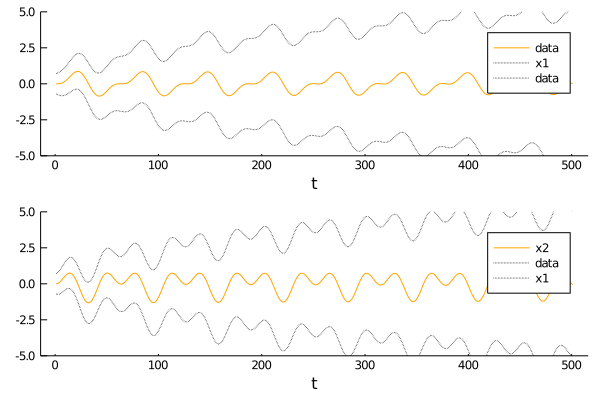

In [47]:
## run the kalman filter without any correction steps
## this should produce the differential equation results. (given same initial conditions)

ps = run_kalman(false)
idx = collect(0:100:length(ps))
#idx = collect(1:150)
idx[1] = 1
ps_fifty = ps[idx]

## plot without the scatter
meansx1 = [mean(p)[1] for p in ps_fifty]
stdx1 = [sqrt(cov(p)[1,1]) for p in ps_fifty]
errorx1 = [meansx1 .+ stdx1 meansx1 .- stdx1]
fx1 = plot(1:length(ps_fifty), meansx1, color="orange", label="filtered x1", grid=false, ylims=(-5, 5))
stx1 = plot!(fx1, 1:length(ps_fifty), errorx1, color="black", linestyle=:dot)

meansx2 = [mean(p)[2] for p in ps_fifty]
stdx2 = [sqrt(cov(p)[2,2]) for p in ps_fifty]
errorx2 = [meansx2 .+ stdx2 meansx2 .- stdx2]
fx2 = plot(1:length(ps_fifty), meansx2, color="orange", label="filtered x2", grid=false, ylims=(-5, 5))
stx2 = plot!(fx2, 1:length(ps_fifty), errorx2, color="black", linestyle=:dot)

plot(fx1, fx2, xaxis="t",label=["data" "x1" "data" "x2"],layout=(2,1))



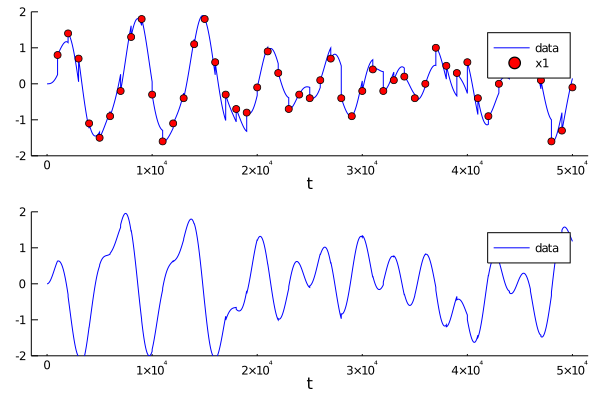

In [50]:
## run the kalman filter with the correction steps and the simulated data
## run the kalman filter without any correction steps
## this should produce the differential equation results. (given same initial conditions)
ps = run_kalman(true)
idx = collect(1000:1000:length(ps))  ## idx should have 50 elements, correpnding to 1, 2, 3, 4, ... in the N array. so the 1000'th element in N is "t = 1"
ps_fifty = ps[1:end]


## plot without the scatter
fx1 = plot(1:length(ps_fifty), [mean(p)[1] for p in ps_fifty], color="blue", label="filtered x1", grid=false, ylims=(-2, 2))
scatter!(idx, first.(ys), color="red", label="observations y")
fx2 = plot(1:length(ps_fifty), [mean(p)[2] for p in ps_fifty], color="blue", label="filtered x2", grid=false, ylims=(-2, 2))
display(plot(fx1, fx2, xaxis="t",label=["data" "x1" "data" "x2"],layout=(2,1)))


